In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics

%matplotlib inline

# Load the Data

In [3]:
df = pd.read_csv("cleaned_plyear_data.csv")

In [4]:
df

,Team,Position,Height,Age,Appearances,Goals,Assists,Yellow_Cards,Second_Yellow_Cards,Red_Cards,Goals_Conceded,Clean_Sheets,Minutes_Played,Days_Injured,Games_Injured,Award,Current_Value,Highest_Value,Position_Encoded,Winger
0,Manchester United,Goalkeeper,196.000000,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
1,Manchester United,Goalkeeper,188.000000,37.0,4,0.000000,0.000000,0.000000,0.0,0.000000,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
2,Manchester United,Defender Centre-Back,185.000000,31.0,8,0.000000,0.000000,0.216346,0.0,0.000000,0.000000,0.000000,416,932,169,7,2000000,20000000,2,0
3,Manchester United,Defender Centre-Back,186.000000,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,2000000,2,0
4,Manchester United,Defender Left-Back,169.000000,23.0,89,0.012619,0.063096,0.227145,0.0,0.000000,0.000000,0.000000,7132,182,15,3,22000000,22000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,4,1
10299,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,4,0
10300,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,4,0
10301,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,4,0


# Aggregat
Aggregating categorical feature

In [6]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Team', 'Position'], dtype='object')

# One hot coding

In [8]:
df = pd.get_dummies(df, columns=categorical_features)

In [9]:
df.shape

(10303, 405)

# Split the players to 4 categories by percentiles

In [11]:
p25 = df['Current_Value'].quantile(0.25)
p50 = df['Current_Value'].quantile(0.50)
p90 = df['Current_Value'].quantile(0.90)

# Function to categorize prices
def categorize_Current_Value(Current_Value):
    if Current_Value < p25:
        return 'bad playere'
    elif Current_Value < p50:
        return 'good player'
    elif Current_Value < p90:
        return 'Excellent player'
    else:
        return 'legend'

# Apply the function to create a new column
df['categorize_Current_Value'] = df['Current_Value'].apply(categorize_Current_Value)

df.drop('Current_Value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['categorize_Current_Value'].value_counts())

categorize_Current_Value
Excellent player    4257
bad playere         2530
good player         2372
legend              1144
Name: count, dtype: int64


# encoder

In [13]:
encoder = LabelEncoder()
df['categorize_Current_Value'] = encoder.fit_transform(df['categorize_Current_Value'])  

# Feature selection

In [15]:
correlation = df.corr(numeric_only=True)
print(correlation['categorize_Current_Value'].sort_values(ascending=False))

categorize_Current_Value        1.000000
Highest_Value                   0.286380
Team_Southampton FC             0.075357
Team_AS Monaco                  0.071601
Appearances                     0.067741
                                  ...   
Team_AJ Auxerre                -0.035094
Team_Real Valladolid CF        -0.036589
Team_Fortaleza Esporte Clube   -0.041784
Team_Elche CF                  -0.044584
Age                            -0.048522
Name: categorize_Current_Value, Length: 405, dtype: float64


In [16]:
threshold = 0.07  
selected_features = correlation[abs(correlation['categorize_Current_Value']) > \
threshold]['categorize_Current_Value'].index
selected_features

Index(['Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value'],
      dtype='object')

In [17]:
selected_features = ['Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value']

# Split data to train and test

In [19]:
X = df.drop(['categorize_Current_Value'], axis=1)
y = df['categorize_Current_Value']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buliding the Model
Bulid aLogisticr Regression Model

In [21]:
model = LogisticRegression()

In [22]:
ridge_model = Ridge()  

In [23]:
lasso_model = Lasso() 

In [24]:
param_grid = {
    'alpha': [ 0.0002, 0.001, 0.01, 0.5, 1, 5,9,8]  
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=10,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=10,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

# Train the model

In [26]:
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [27]:
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [28]:
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [29]:
grid_search_ridge.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0002, 0.001, 0.01, 0.5, 1, 5, 9, 8]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0002, 0.001, 0.01, 0.5, 1, 5, 9, 8]},
             scoring='neg_mean_squared_error', verbose=1)

# Test the model

In [41]:
y_pred = model.predict(X_test_scaled)


# Interpretation of the Model

In [44]:
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Height,-0.008474
Age,0.746062
Appearances,0.664221
Goals,-0.033380
Assists,-0.064684
...,...
Position_midfield-AttackingMidfield,-0.043715
Position_midfield-CentralMidfield,-0.024324
Position_midfield-DefensiveMidfield,-0.003752
Position_midfield-LeftMidfield,-0.013534


In [45]:
model.coef_

array([[ 6.39914545e-03,  1.96974550e-01,  5.40636632e-01, ...,
         1.29779012e-02,  1.21624610e-03, -4.37262736e-03],
       [-7.98828014e-02,  5.67003900e-01, -1.15896797e+00, ...,
        -1.08291256e-01, -4.66156792e-02, -3.53090173e-03],
       [-8.47378556e-03,  7.46061866e-01,  6.64220506e-01, ...,
        -3.75186331e-03, -1.35343516e-02, -1.31776489e-02],
       [ 8.19574415e-02, -1.51004032e+00, -4.58891714e-02, ...,
         9.90652177e-02,  5.89337848e-02,  2.10811779e-02]])

In [46]:
print(model.intercept_) 

[ 2.77775601 -1.07665978  1.3544207  -3.05551694]


# Evaluating the Model 

In [48]:
base_model = round(df['categorize_Current_Value'].value_counts()[1]/df.shape[0]*100, 2)
base_model

24.56

#### accuracy

In [54]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6690926734594856

In [56]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.7429022082018928

In [58]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[663,  46, 102,  39],
       [ 65, 354,  83,   2],
       [159, 122, 201,   1],
       [ 63,   0,   0, 161]], dtype=int64)

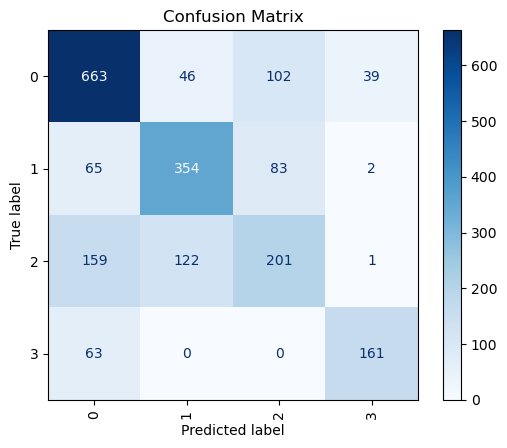

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#### Precision

In [63]:
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.67


#### Recall

In [66]:
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.65


#### F1

In [69]:
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.66


# Overfitting Check

In [72]:
traine_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
print ('Train accuracy',traine_accuracy)
print ('Test accuracy',test_accuracy)

Train accuracy 0.7429022082018928
Test accuracy 0.6690926734594856


# Underfitting Check

In [ ]:
# no  Underfitting 